### Importing Python Modules

In [1]:
!pip install torchvision, transformers

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageFile, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from textwrap import wrap

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from transformers import AdamW, BertModel, BertTokenizer, DistilBertModel

from tqdm.notebook import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")


### Reading the dataset

In [3]:
gossicop_fake = pd.read_csv('datasets/gossipcop_fake.csv')
gossicop_real = pd.read_csv('datasets/gossipcop_real.csv')
politifact_fake = pd.read_csv('datasets/politifact_fake.csv')
politifact_real = pd.read_csv('datasets/politifact_real.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3549 entries, 13338 to 14116
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3549 non-null   object
 1   news_url   3549 non-null   object
 2   title      3549 non-null   object
 3   tweet_ids  3345 non-null   object
 4   labels     3549 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 166.4+ KB


#### Adding labels to the dataset

In [5]:
gossicop_fake['labels']= 0
gossicop_real['labels']= 1

politifact_fake['labels']= 0
politifact_real['labels']= 1

2129 710 710


#### Concatenating the dataset (real and fake) and shuffling the dataset

In [4]:
df_gossip = pd.concat([gossicop_real, gossicop_fake], ignore_index=True)
df_gossip = shuffle(df_gossip)

df_politifact = pd.concat([politifact_real, politifact_fake], ignore_index=True)
df_politifact = shuffle(df_politifact)

In [7]:
df_gossip.columns, df_politifact.columns

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
df_gossip.title.isnull().sum()

0

In [8]:
df_politifact.title.isnull().sum()

CPU is allocated.


In [8]:
df_gossip.head()

,id,news_url,title,tweet_ids,labels
2773,gossipcop-927596,https://www.miami.com/miami-news/luis-fonsi-ca...,Luis Fonsi can’t feel bad about turning 40. Hi...,985738906435022848\t985739320030973952\t985740...,1
8510,gossipcop-884272,https://www.etonline.com/sofia-richie-and-scot...,Sofia Richie and Scott Disick Share a Kiss on ...,NaN,1
6256,gossipcop-866058,https://www.hollywoodreporter.com/live-feed/ba...,JoJo Breaks Down Her Final Two Men Ahead of 'T...,884595148868526081\t884595387692187648\t884595...,1
7009,gossipcop-873690,https://people.com/home/tarek-el-moussa-on-pro...,Tarek and Christina El Moussa Produce New HGTV...,897566644884590592\t897566802783477760\t897566...,1
17871,gossipcop-109358738,www.dailymail.co.uk/tvshowbiz/article-4862870/...,Katie Holmes glows after confirming Jamie Foxx...,905845659198205953\t905875949257940995\t905884...,0


In [9]:
df_politifact.head()

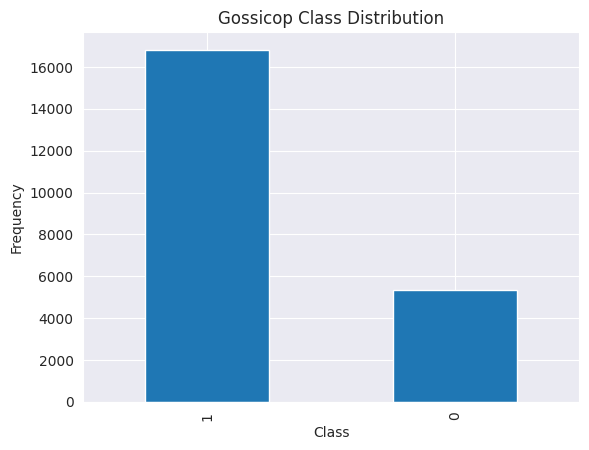

In [10]:
# Get the class distribution
class_distribution = df_gossip['labels'].value_counts()

# Plot the class distribution
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Gossicop Class Distribution')
plt.show()

In [10]:
# Get the class distribution
class_distribution = df_politifact['labels'].value_counts()

# Plot the class distribution
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Politificat Class Distribution')
plt.show()

In [11]:
len(df_gossip), len(df_politifact)

### To Choose the dataset to use (Images and CSV)

### 1. To Run on the politifact Dataset, run the following cell

In [14]:
df = df_politifact.copy()
image_path = 'politifact_images/'

CPU times: user 246 µs, sys: 131 µs, total: 377 µs
Wall time: 364 µs


### 2. To Run on the gossip dataset, run the following cell

In [53]:
df = df_gossip.copy()
image_path = 'gossicop_images/'

## Split the data into Train, Test and Validation

In [54]:
df.info()

In [38]:
import read_data
df = read_data.load_dataset_gossipcop()

In [55]:
df.info()

In [56]:
df.head()

In [40]:
# Split the data into train (60%), val (20%), and test (20%) sets
df_train, temp_df = train_test_split(df, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check the length of each set
print(len(df_train), len(df_val), len(df_test))


In [57]:
# # Split the data into train (70%), val (15%), and test (15%) sets
# df_train, temp_df = train_test_split(df, test_size=0.3, random_state=42)
# df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)
#
# # Check the length of each set
# print(len(df_train), len(df_val), len(df_test))

tensor([0.2649, 0.7351])


### Loading Pretrained Transformer Models and Resnet

In [59]:
# Load pre-trained models
resnet = models.resnet18(pretrained=True) # resnet18, resnet34
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last layer to get embeddings
bert = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


### Assigning device to train the model

In [45]:
device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == "cpu":
    print("CPU is allocated.")
else:
    print("GPU is allocated.")

,id,news_url,title,tweet_ids,labels
12233,gossipcop-876674,http://liverampup.com/entertainment/william-le...,William Levy Allegedly Cheated On Wife-Like Gi...,902708815526846464\t902708829611327488\t902708...,0
13258,gossipcop-865215,http://toofab.com/2017/07/06/spice-girls-wanna...,"Nicole Kidman, James Franco, Milo Ventimiglia ...",882988553743085572\t882988925802999808\t882988...,0
20302,gossipcop-667682841,ew.com/tv/2017/07/13/billy-bush-not-hosting-fo...,"No, Billy Bush isn't hosting a show on Fox",3085644868\t3206664939\t3646127827\t1014232385...,1
13037,gossipcop-844552,https://www.fame10.com/entertainment/real-hous...,Real Housewives: Ranking The 12 Shadiest Signi...,854742061550936064\t854742374433529856\t854742...,0
13988,gossipcop-899206,https://www.dailymail.co.uk/tvshowbiz/article-...,Chloë Moretz 'wanted to hide' after Brooklyn B...,939565900398768129\t939566081613504512\t939566...,0


### Dataloader
- For each of the title in the csv, when the image exist, read it and apply transformations (like converting to tensors)
- When the post does not have an associated image, use a black image
- Dynamically store the images depending on how many images are in the folder and stack them. The dataloader will work with any arbitrary number of images and thus no need to modify the loading when more images are incorporated

In [ ]:
# Custom dataset class
import pdb
class MultiModalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_folder, tokenizer, transform):
        self.df = df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # pdb.set_trace()
        text, post_id, labels = row["title"], row["id"], row["labels"]
        labels = torch.tensor(labels, dtype=torch.long)

        IMG_SIZE = 3
        images_path = os.path.join(self.image_folder, post_id)
        images = []
        if os.path.exists(images_path):
            image_files = os.listdir(images_path)

            for img in image_files:
                if len(images) >= IMG_SIZE:
                    break
                try:
                    image = Image.open(os.path.join(images_path, img)).convert('RGB')
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    images.append(image)
                # Handling Exception and randomly initializing pixels
                except Exception:
                    images.append(Image.new("RGB", (224, 224), "black"))

        while len(images) < IMG_SIZE:
            images.append(Image.new("RGB", (224, 224), "black"))
            
        inputs = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True)
        images = [self.transform(img) for img in images]
        images_tensor = torch.stack(images)
        sample = {'text': inputs, 'images': images_tensor, 'labels': labels}

        return sample


### Data Augmentation

In [10]:
# Transform function for image processing (training)
# Performing data augmentation by random resizing, cropping
# and flipping images in order to artificially create new
# image data per training epoch
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

In [11]:
# # Define image transformations
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

In [12]:
# Just normalization for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

In [13]:
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

In [14]:
%%time
# Create the dataset
BATCH_SIZE = 4


train_dataset = MultiModalDataset(df_train, image_path, tokenizer, train_transform )
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)

val_dataset = MultiModalDataset(df_val, image_path, tokenizer, train_transform )
validate_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2)

test_dataset = MultiModalDataset(df_test, image_path, tokenizer, val_transform )
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2)

CPU times: user 174 µs, sys: 115 µs, total: 289 µs
Wall time: 288 µs


## Model Implementation
- The model has the following major components
    - Pretrained BERT model for getting embeddings for the title and a pretrained resnet for the image embeddings 
    - Performs transfer learning based on the pretrained models (BERT and RESNET)
    - Tokenization of the title input using transformers
    - Cross attention mechanism implemented with 4 attention heads (Increased the number of heads for improvement in performance)
        - Each image attents to a title i.e if there are 5 images in the article, they will attent to the same title or text given by id 
        - For each of the image or if it exists for a certain post, feed in the images and compute cross attention for the image to title attention (each image attenting to the post)
        - The attention query in this case is the text (title), key is the image embeddings and value is the image embeddings
        - It is flexible enough to take in any number of images per post
        - The cross attention output is then averaged 
     - Additional functionalities like adding batch normalization to the image model layers, ReLU activation function for non linearity and dropout 


In [15]:
import pdb

In [31]:
class MultiModalModel(nn.Module):
    def __init__(self, bert, resnet):
        super().__init__()
        self.bert = bert
        self.resnet = resnet
        self.drop = nn.Dropout(p=0.3)
        
        # Defining the attention mechanism for the model
        self.image_to_title_attention = nn.MultiheadAttention(bert.config.hidden_size, num_heads=4)  # Increase num_heads
        
        self.linear = nn.Linear(2048, bert.config.hidden_size)
        self.norm = nn.BatchNorm1d(bert.config.hidden_size)
        self.relu = nn.ReLU()  # Add ReLU activation
        self.hidden = nn.Linear(bert.config.hidden_size, bert.config.hidden_size)  # Add hidden layer
        self.classifier = nn.Linear(bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, images):
        # Process text input
        # pdb.set_trace()
        text_output = self.bert(**inputs).last_hidden_state[:, 0, :]

        # Process image input
        # print(torch.unsqueeze(images[0], 0).view(-1).shape)
        img_embeddings = [self.resnet(img.unsqueeze(0)).view(-1) for img in images]
        img_embeddings = torch.stack(img_embeddings)
        img_embeddings = self.linear(img_embeddings)
        img_embeddings = self.norm(img_embeddings)  # Apply batch normalization
        img_embeddings = self.relu(img_embeddings)  # Apply ReLU activation

        # Calculate attention between text and each image
        attention_outputs = []
        for img_emb in img_embeddings:
            img_emb = img_emb.view(1, 1, 768)
            # text_output.unsqueeze(1).shape (1, batch_size, hidden_size) => (1, 2, 768)
            #img_emb.shape => (1, 1, hidden_size)
            att_out, _ = self.image_to_title_attention(text_output.unsqueeze(1), img_emb, img_emb)
            attention_outputs.append(att_out)

        # Average attention outputs
        attention_output = torch.stack(attention_outputs).mean(dim=0)

        # Classifier
        logits = self.hidden(attention_output.squeeze(1))  # Apply hidden layer
        logits = self.drop(logits)  # Apply dropout to the hidden layer
        logits = self.classifier(logits)
        return self.sigmoid(logits)
       


### Model Training Configuration
- Computing the class weights for the dataset so that we put different weights on the classes. It will help in class balancing during training

In [32]:
def get_class_weights(dataframe):
    
    # Count labels per class / subtype of Fake News in training set split
    # in sorted order 0, 1 and put into label_count list
    label_count = [dataframe["labels"].value_counts().sort_index(0)[0],
                   dataframe["labels"].value_counts().sort_index(0)[1]]

    # Calculate weights per class by subtracting from 1 label_count per class divided
    # by sum of all label_counts
    class_weights = [1 - (x / sum(label_count)) for x in label_count]

    class_weights = torch.FloatTensor(class_weights)
    return class_weights

# Training Routine
- Training routing for the model. Some of the additional techniques applied include clipping the gradients

In [33]:
def train_model(model, data_loader, criterion, optimizer, device, num_examples):
    print("Training model in progress..")
    print("-" * 15)
    model = model.train()
    train_losses = []
    correct_preds = 0
    for data in tqdm(data_loader):
        inputs = {k: v.squeeze(1).to(device) for k, v in data['text'].items()}
        images = data['images'].to(device)
        labels = data['labels'].to(device)
    
        # Forward pass
        outputs = model(inputs, images.squeeze(1))
        _, preds = torch.max(outputs, dim=1)
        train_loss = criterion(outputs.squeeze(), labels.float())
        
        correct_preds += torch.sum(preds == labels)
        train_losses.append(train_loss.item())
        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
            
    # Return train_acc and train_loss values
    return correct_preds.double() / num_examples, np.mean(train_losses)


In [34]:
def evaluate_model(model, data_loader, loss_function, device, num_examples):
    print("validation of the model in progress...")
    print("-" * 15)
    model = model.eval()
    val_losses = []
    correct_preds = 0
    with torch.no_grad():
        for data in tqdm(data_loader):
            # Move data to the device
            inputs = {k: v.squeeze(1).to(device) for k, v in data['text'].items()}
            images = data['images'].to(device)
            labels = data['labels'].to(device)
            
            outputs = model(inputs, images.squeeze(1))
            
            _, preds = torch.max(outputs, dim=1)
            
            val_loss = loss_function(outputs.squeeze(), labels.float())
            correct_preds += torch.sum(preds == labels)
            val_losses.append(val_loss.item())
    return correct_preds.double() / num_examples, np.mean(val_losses)
                

### Defining the Model Hyperparameters 

In [35]:
# Calculate class weights on basis of training split dataframe and print weight tensor
class_weights = get_class_weights(df_train)

print(class_weights)

tensor([0.2635, 0.7365])


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalModel(bert, resnet)
model.to(device)

MultiModalModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [37]:
EPOCHS = 10
# Initializing weighted Cross Entropy Loss function and assignment to device
loss_function = nn.CrossEntropyLoss(weight=class_weights).to(device)
# Set up the loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [38]:
df_train.head()

,id,news_url,title,tweet_ids,labels
14686,gossipcop-905277,https://www.channel24.co.za/Gossip/News/watch-...,WATCH: David Beckham launches sexy ad campaign...,950901801271922689\t950902108160577536\t950902...,0
17412,gossipcop-6828006698,people.com/style/justin-bieber-hailey-baldwin-...,Are Justin Bieber and Hailey Baldwin Already M...,74339314045157376\t237856098332340224\t5924446...,1
1326,gossipcop-865378,https://people.com/tv/inside-julianne-hough-br...,Dancing Under the Stars: Julianne Hough's Perf...,883266867535773696\t883267037358727168\t883267...,0
21761,gossipcop-9915206962,www.inquisitr.com/4790273/blake-shelton-jokes-...,Blake Shelton Jokes Gwen Stefani ‘Gave Birth T...,964814953143291904\t964819241932386304\t964819...,1
2412,gossipcop-850516,https://www.thewrap.com/once-upon-time-season-...,‘Once Upon a Time': Creators Defend Cast Shake...,NaN,0


## Training the model

In [39]:
best_accuracy = 0

# Iteration times the total number of epochs
for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_model(
        model,
        train_dataloader,
        loss_function,
        optimizer,
        device,
        len(df_train)
    )
    

    print(f"Train loss {train_loss} | Accuracy {train_acc}")
    print()
    val_acc, val_loss = evaluate_model(
            model,
            validate_dataloader,
            loss_function,
            device,
            len(df_val)
    )

    print(f"Val   loss {val_loss} | Accuracy {val_acc}")
    print()

print()
print("Completed Training!")
print("-" * 20)

Epoch 1/10
----------
Training model in progress..
---------------


  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 5.80 GiB total capacity; 5.03 GiB already allocated; 2.94 MiB free; 5.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Plotting the output results

In [ ]:
# Plotting training and validation accuracy curves across the epochs
plt.plot(train_acc, color="green", label="Training Accuracy")
plt.plot(val_acc, color="red", label="Validation Accuracy")

plt.title("Training History")
# Defining x- and y-axis labels
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss, color="blue", label="Training Loss")
plt.plot(val_loss, color="orange", label="Validation Loss")
plt.title("Training History")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Testing the models 

In [ ]:
def test_model(model, data_loader, loss_function, device, num_examples):
    print("Testing model in progress...")
    print("-" * 15)
    model.eval()
    test_losses = []
    correct_preds = 0
    predictions = []
    prediction_probs = []
    real_labels = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs = {k: v.squeeze(1).to(device) for k, v in data['text'].items()}
            images = data['images'].to(device)
            labels = data['labels'].to(device)
            
            outputs = model(inputs, images.squeeze(1))
            _, preds = torch.max(outputs, dim=1)
            test_loss = loss_function(outputs.squeeze(), labels.float())
            correct_preds += torch.sum(preds == labels)
            test_losses.append(test_loss.item())
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_labels.extend(labels)
    test_acc = correct_preds.double() / num_examples
    test_loss = np.mean(test_losses)
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    real_labels = torch.stack(real_labels)
    
    # Return test_acc, test_loss, predictions, prediction_probs, real_labels
    return test_acc, test_loss, predictions, prediction_probs, real_labels

In [ ]:
# Testing model on test data split and initilaizing test values
test_acc, test_loss, y_preds, y_prediction_probs, y_test = test_model(
    model,
    test_dataloader,
    loss_function,
    device,
    len(df_test)
)



In [ ]:
# Printing model test accuracy
print(f"Model testing accuracy for classifier:  {test_acc*100}%")

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, auc

In [ ]:
# Plotting classification report
print(classification_report(y_test.cpu(), y_preds.cpu(), target_names=CLASS_NAMES))

In [ ]:
# or individual evaluations of the results
print("f1 score is: ", f1_score(y_test.cpu(), y_preds.cpu(), average='macro'))
print("precision score is: ", precision_score(y_test.cpu(), y_preds.cpu(), average='macro'))
print("recall score is: ", recall_score(y_test.cpu(), y_preds.cpu(), average='macro'))


In [ ]:
print("auc score for the model: ", roc_auc_score(y_test.cpu(), 1 - y_prediction_probs.cpu()[:,1], multi_class="ovo", average="macro"))

In [ ]:
def plot_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    # Set x- and y-axis labels
    plt.ylabel("Fakeddit Dataset Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix for the model")
    plt.tight_layout
    plt.show()

# Initialize confusion_matrix with y_test (ground truth labels) and predicted labels
cm = confusion_matrix(y_test.cpu(), y_preds.cpu())
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
plot_confusion_matrix(df_cm)


## Plotting AUC and ROC score for the models

In [ ]:
#create ROC curve
def plot_auc(y_test, y_pred_proba):
    fpr, tpr, _ = metrics.roc_curve(y_test,  1 - y_pred_proba[:,1])
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve of the model")
    plt.tight_layout
    plt.show()

In [ ]:
plot_auc(y_test.cpu(), y_prediction_probs.cpu())